In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Input, Reshape, Lambda, Dropout, Flatten 
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization, SeparableConv2D, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
# K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

# BCNN

In [2]:
def _outer_product(x):
    '''Calculate outer-products of two tensors.
    Args:
        x: a list of two tensors.
        Assume that each tensor has shape = (size_minibatch, total_pixels, size_filter)
    Returns:
        Outer-products of two tensors.
    '''
    return K.batch_dot(x[0], x[1], axes=[1, 1]) / x[0].get_shape().as_list()[1]

def _signed_sqrt(x):
    '''Calculate element-wise signed square-root.
    Args:
        x: input tensor.
    Returns:
        Element-wise signed square-root tensor.
    '''
    return K.sign(x) * K.sqrt(K.abs(x) + 1e-9)

def _l2_normalize(x, axis=-1):
    '''Calculate L2 normalization.
    Args:
        x: input tensor.
        axis: axis for narmalization.
    Returns:
        L2 normalized tensor.
    '''
    return K.l2_normalize(x, axis=axis)
def buil_bcnn(
        size_height=150,
        size_width=150,
        no_class=2,
        no_last_layer_backbone=17,
        name_activation='softmax',
    ):
    # Load model
    input_tensor = Input(shape=[size_height, size_width, 3])
    pre_train_model = VGG16(
        input_tensor=input_tensor,
        include_top=False,weights = None)
    pre_train_model.load_weights("C:\\Users\\kyrie\\.keras\\models\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
    # Pre-trained weights
    for layer in pre_train_model.layers:
        layer.trainable = False


    ######################
    # Combine two models #
    ######################

    # Extract features form detecotr
    model_detector = pre_train_model
    output_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape

    # Extract features from extractor
    model_extractor = pre_train_model
    output_extractor = model_extractor.layers[no_last_layer_backbone].output
    shape_extractor = model_extractor.layers[no_last_layer_backbone].output_shape

    # Reshape tensor to (minibatch_size, total_pixels, filter_size)
    output_detector = Reshape(
        [shape_detector[1]*shape_detector[2], shape_detector[-1]])(output_detector)
    output_extractor = Reshape(
        [shape_extractor[1]*shape_extractor[2], shape_extractor[-1]])(output_extractor)

    # Outer-products
    x = Lambda(_outer_product)([output_detector, output_extractor])
    # Reshape tensor to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    # Signed square-root
    x = Lambda(_signed_sqrt)(x)
    # L2 normalization
    x = Lambda(_l2_normalize)(x)


    ###############################
    # Attach full-connected layer #
    ###############################

    # FC layer
    x = Dense(
        units=no_class)(x)
    output_tensor = Activation(name_activation)(x)

    model_bcnn = Model(inputs=[input_tensor], outputs=[output_tensor])

    # Compile
    model_bcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # print('-------- Mode summary --------')
    # print(model_bcnn.summary())
    # print('------------------------------')

    return model_bcnn

In [3]:
BCNN = buil_bcnn()
BCNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 150, 150, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 150, 150, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 75, 75, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [4]:
BCNN.load_weights('BCNN.hdf5')

In [5]:
with open('X_test_1.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_test_1.pkl', 'rb') as file:
    y_test =pickle.load(file)

In [6]:
y_test = tf.one_hot(y_test, 2)

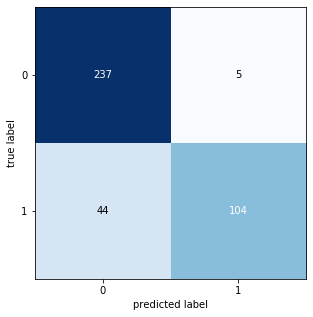

In [7]:
pred_BCNN = BCNN.predict(X_test)
pred1_BCNN = np.argmax(pred_BCNN,axis = 1) 
y_test_BCNN = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test_BCNN, pred1_BCNN)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [8]:
print(classification_report(y_test_BCNN, pred1_BCNN))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       242
           1       0.95      0.70      0.81       148

    accuracy                           0.87       390
   macro avg       0.90      0.84      0.86       390
weighted avg       0.89      0.87      0.87       390



# InceptionV3

In [9]:
base_model = InceptionV3(include_top=False , input_shape=(150,150,3))
x = base_model.output
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
t_model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
t_model.load_weights('BCNN1.hdf5')

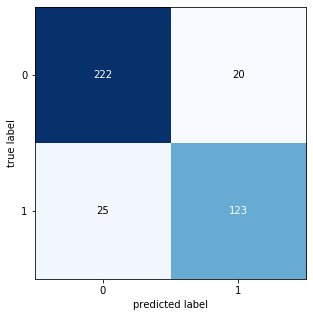

In [11]:
pred_V3 = t_model.predict(X_test)
pred1_V3 = np.argmax(pred_V3,axis = 1) 
y_test_V3 = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test_V3, pred1_V3)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [12]:
print(classification_report(y_test_V3, pred1_V3))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       242
           1       0.86      0.83      0.85       148

    accuracy                           0.88       390
   macro avg       0.88      0.87      0.88       390
weighted avg       0.88      0.88      0.88       390



# CNN

In [13]:
K.set_image_data_format('channels_first')
X_test=X_test.reshape(390,3,150,150)

In [14]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 64, 37, 37)        1

In [15]:
model.load_weights('BCNN2.hdf5')

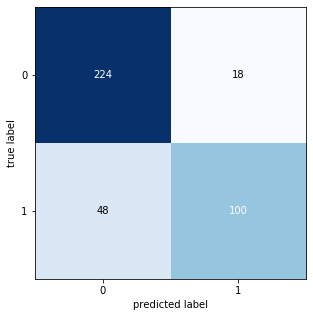

In [16]:
pred_CNN = model.predict(X_test)
pred1_CNN = np.argmax(pred_CNN,axis = 1) 
y_test_CNN = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test_CNN, pred1_CNN)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [17]:
print(classification_report(y_test_CNN, pred1_CNN))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       242
           1       0.85      0.68      0.75       148

    accuracy                           0.83       390
   macro avg       0.84      0.80      0.81       390
weighted avg       0.83      0.83      0.83       390



In [18]:
def ROC (prediction ,test, trueclass, falseclass):
    TP=0
    FN=0
    FP=0
    TN=0
    for i in range (test.shape[0]):
        if prediction[i]==trueclass and test[i]==trueclass:
            TP +=1
        elif prediction[i]==falseclass and test[i]==falseclass:
            TN +=1
        elif prediction[i]==trueclass and test[i]==falseclass:
            FP +=1
        elif prediction[i]==falseclass and test[i]==trueclass:
            FN +=1
    return FP/(FP+TN), TP/(TP+FN)

In [19]:
import copy
def process(p,test):
    x=[]
    y=[]
    p = p.tolist()
    p.sort(reverse = True)
    for i in np.arange(0,1,0.03):
        predict=[]
        for j in p:
            if j>=i:
                predict.append(0)
            else:
                predict.append(1)
        r1, r2 = ROC(predict, test, 0, 1)
        x.append(r1)
        y.append(r2)
    return x,y

In [20]:
x1,y1 = process(pred_BCNN[:,0],y_test_BCNN)
x2,y2 = process(pred_CNN[:,0],y_test_CNN)
x3,y3 = process(pred_V3[:,0],y_test_V3)
x4 = np.arange(0,1.1,0.1)
y4 = np.arange(0,1.1,0.1)

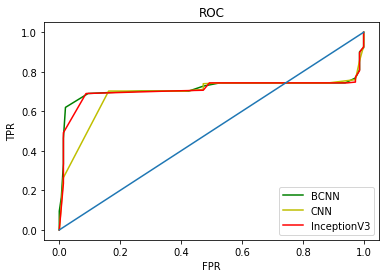

In [22]:
plt.plot(x1,y1,c='g',label='BCNN')
plt.plot(x2,y2,c='y',label='CNN')
plt.plot(x3,y3,c='r',label='InceptionV3')
plt.plot(x4,y4)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)